**ISCTE - Lisbon University Institute**

Master Degree in Artificial Intelligence
Advanced Machine Learning
2025/2026 - 1st semester

*Project Assignement*
Version 1.0 (2025-11-18)

    This work must be carried individually or in pairs of 2 students (recommended).
    Deadline: Saturday, December 6, until 11:59 PM.
    The project presentation will take place on December 9, during class time.

*Part 1 – POS Tagging*
The goal of this assignment is to develop and compare models for Part-of-Speech (POS) tagging using two different deep learning architectures:

    *LSTM-based models*
    *Pre-trained transformer-based models*

Students will train or fine-tune, evaluate, and analyze the performance of these models on the provided dataset.

**Dataset**

For this part we will be using the Universal Dependencies English Web Treebank data (v2.17 - 2025-11-15). The data is already split into training, development and test subsets.

en_ewt-ud-train.conllu
en_ewt-ud-dev.conllu
en_ewt-ud-test.conllu

Each one of these subsets contain words, grouped by sentences, each one of them labeled with the corresponding POS tag. After downloading the data, the following function can be used to load each one of the datasets individually.

**Task 1.1 - Train an LSTM-Based Model**

    Train a sequence model (e.g. LSTM) on the training set.
    Include an embedding layer. Pre-trained embeddings, such as Glove embeddings, are avaliable for download and can be used.
    Output a POS tag per token using a softmax classifier.

Evaluate your model on the test set

    Report the global performance using Accuracy
    Report the performance per-class using Precision, Recall, F1-score
    
Report training time, model size, and any hardware constraints.

In [217]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [218]:
# --- Funções de Leitura de Dados ---

def read_conllu_file(filepath):
    """
    Read a CoNLL-U format file and extract words and POS tags sentence by sentence.
    
    Args:
        filepath: Path to the CoNLL-U file
        
    Returns:
        A list of dictionaries, each containing 'words' and 'pos_tags' lists for a sentence
    """
    sentences = []
    current_sentence = {'words': [], 'pos_tags': []}
    
    with open(filepath, "r", encoding="utf-8") as data_file:
        for line in data_file:
            if line.startswith("#"):
                # Skip comment lines
                pass
            elif line.strip() == "":
                # Empty line marks end of sentence
                if current_sentence['words']:  # Only add non-empty sentences
                    sentences.append(current_sentence)
                    current_sentence = {'words': [], 'pos_tags': []}
            else:
                # Parse the token line
                fields = line.split("\t")
                word, pos = fields[1], fields[3]
                current_sentence['words'].append(word)
                current_sentence['pos_tags'].append(pos)
    
    return sentences

#load data
TRAIN = "./data/en_ewt-ud-train.conllu"
DEV = "./data/en_ewt-ud-dev.conllu"
TEST = "./data/en_ewt-ud-test.conllu"
GLOVE300 = "../Part1/data/wiki_giga_2024_300_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05_combined.txt"

# --- 1) Carregar Dados ---
try:
    train_sents = read_conllu_file(TRAIN)
    val_sents = read_conllu_file(DEV)
    test_sents = read_conllu_file(TEST)
    print("Loaded sentences:", len(train_sents), len(val_sents), len(test_sents))
except FileNotFoundError as e:
    print(f"Erro: Ficheiro de dados não encontrado: {e.filename}. Certifique-se de que os ficheiros CoNLL-U estão em './data/'")
    exit()

# Display preview
print(f"Total sentences: {len(val_sents)}")
print(f"First 3 sentences:")
for i, sent in enumerate(val_sents[:3]):
    print(f"Sentence {i+1}:")
    print(f"  Words: {sent['words']}")
    print(f"  POS tags: {sent['pos_tags']}")

Loaded sentences: 12544 2001 2077
Total sentences: 2001
First 3 sentences:
Sentence 1:
  Words: ['From', 'the', 'AP', 'comes', 'this', 'story', ':']
  POS tags: ['ADP', 'DET', 'PROPN', 'VERB', 'DET', 'NOUN', 'PUNCT']
Sentence 2:
  Words: ['President', 'Bush', 'on', 'Tuesday', 'nominated', 'two', 'individuals', 'to', 'replace', 'retiring', 'jurists', 'on', 'federal', 'courts', 'in', 'the', 'Washington', 'area', '.']
  POS tags: ['PROPN', 'PROPN', 'ADP', 'PROPN', 'VERB', 'NUM', 'NOUN', 'PART', 'VERB', 'VERB', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'ADP', 'DET', 'PROPN', 'NOUN', 'PUNCT']
Sentence 3:
  Words: ['Bush', 'nominated', 'Jennifer', 'M.', 'Anderson', 'for', 'a', '15', '-', 'year', 'term', 'as', 'associate', 'judge', 'of', 'the', 'Superior', 'Court', 'of', 'the', 'District', 'of', 'Columbia', ',', 'replacing', 'Steffen', 'W.', 'Graae', '.']
  POS tags: ['PROPN', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'ADP', 'DET', 'NUM', 'PUNCT', 'NOUN', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'ADP', 'DET', 'ADJ', 'PROP

In [219]:
# --- Constants ---
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"
BATCH_SIZE = 32
EMBEDDING_DIM = 300
HIDDEN_DIM = 128

# --- Vocabulary Helpers ---
def build_vocab(sentences, min_freq=1):
    """Builds word and tag vocabularies from the dataset."""
    word_freq = {}
    tag_set = set()
    
    for sent in sentences:
        for word, tag in zip(sent['words'], sent['pos_tags']):
            word_freq[word] = word_freq.get(word, 0) + 1
            tag_set.add(tag)
            
    # Mappings: Word to Index
    word2idx = {PAD_TOKEN: 0, UNK_TOKEN: 1}
    idx2word = {0: PAD_TOKEN, 1: UNK_TOKEN}
    
    current_idx = 2
    for word, freq in word_freq.items():
        if freq >= min_freq:
            word2idx[word] = current_idx
            idx2word[current_idx] = word
            current_idx += 1
            
    # Mappings: Tag to Index
    tag2idx_lstm = {PAD_TOKEN: 0}
    idx2tag = {0: PAD_TOKEN}
    
    current_idx = 1
    for tag in sorted(list(tag_set)):
        tag2idx_lstm[tag] = current_idx
        idx2tag[current_idx] = tag
        current_idx += 1
        
    return word2idx, tag2idx_lstm

# Build vocab based on TRAIN set only to avoid data leakage~
word2idx, tag2idx_lstm = build_vocab(train_sents)
idx2tag = {v: k for k, v in tag2idx_lstm.items()}

print(f"\nVocab Size: {len(word2idx)}")
vocab_size = len(word2idx)
print(f"Tagset Size: {len(tag2idx_lstm)}")
num_tags = len(tag2idx_lstm)


Vocab Size: 20203
Tagset Size: 19


In [220]:
def load_glove_embeddings(glove_path, word2idx, embedding_dim,
                          unk_token="<unk>", lower=True,
                          random_seed=42, scale=0.05,
                          save_numpy_path=None):
    """
    Load GloVe text file into a numpy array shaped (vocab_size, embedding_dim)
    aligned with word2idx. Words not found in GloVe get small random vectors.

    Args:
      glove_path (str): path to GloVe text file (each line: word v1 v2 ...).
      word2idx (dict): mapping word -> index that your model uses.
      embedding_dim (int): expected embedding dim (e.g., 300).
      unk_token (str): token used for unknown word index (if present in word2idx).
      lower (bool): match lowercase words to GloVe entries.
      random_seed (int), scale (float): initializer params for OOV vectors.
      save_numpy_path (str|None): if provided, saves the numpy array for faster reload.

    Returns:
      np.ndarray shape (vocab_size, embedding_dim)
    """
    rng = np.random.RandomState(random_seed)
    vocab_size = len(word2idx)
    # initialize with small random values
    embeddings = rng.normal(loc=0.0, scale=scale, size=(vocab_size, embedding_dim)).astype(np.float32)

    # Optional: set a fixed vector for padding or unk if you want zeros
    if "<pad>" in word2idx:
        embeddings[word2idx["<pad>"]] = np.zeros(embedding_dim, dtype=np.float32)
    if unk_token in word2idx:
        embeddings[word2idx[unk_token]] = rng.normal(loc=0.0, scale=scale, size=(embedding_dim,)).astype(np.float32)

    found = 0
    with open(glove_path, "r", encoding="utf-8", errors="ignore") as fh:
        for line in fh:
            parts = line.rstrip().split(" ")
            if len(parts) <= embedding_dim:
                # malformed line
                continue
            word = parts[0]
            if lower:
                key = word.lower()
            else:
                key = word
            try:
                vec = np.asarray(parts[1:], dtype=np.float32)
            except ValueError:
                # bad numeric conversion
                continue
            if vec.shape[0] != embedding_dim:
                continue
            # check if word is in our vocab (try exact and lower forms)
            if key in word2idx:
                embeddings[word2idx[key]] = vec
                found += 1
            # sometimes your vocab has forms like "dog" and GloVe has "dog," etc.
            # but try to keep matching simple to avoid false positives.

    print(f"Loaded GloVe: found {found}/{vocab_size} words from the provided vocabulary.")
    if save_numpy_path:
        np.save(save_numpy_path, embeddings)
        print(f"Saved embeddings numpy to {save_numpy_path}")
    return embeddings

glove_embeddings_matrix = load_glove_embeddings(GLOVE300, word2idx, EMBEDDING_DIM, unk_token=UNK_TOKEN, lower=True)

Loaded GloVe: found 11861/20203 words from the provided vocabulary.


In [221]:
class POSDataset(Dataset):
    def __init__(self, sentences, word2idx, tag2idx_lstm):
        self.data = []
        for sent in sentences:
            # Convert words to indices (use UNK if not found)
            word_indices = [word2idx.get(w, word2idx[UNK_TOKEN]) for w in sent['words']]
            # Convert tags to indices
            tag_indices = [tag2idx_lstm[t] for t in sent['pos_tags']]
            self.data.append((torch.tensor(word_indices), torch.tensor(tag_indices)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def collate_fn(batch):
    """Pads sequences so they are all the same length in a batch."""
    words, tags = zip(*batch)
    words_padded = pad_sequence(words, batch_first=True, padding_value=0)
    tags_padded = pad_sequence(tags, batch_first=True, padding_value=0)
    return words_padded, tags_padded

# Initialize DataLoaders
train_data = POSDataset(train_sents, word2idx, tag2idx_lstm)
test_data = POSDataset(test_sents, word2idx, tag2idx_lstm)
val_data = POSDataset(val_sents, word2idx, tag2idx_lstm)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [222]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim, hidden_dim, num_layers=1, pretrained_embeddings=None):
        super(LSTMTagger, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Load Glove embeddings if provided
        if pretrained_embeddings is not None:
            print("Loading pretrained embeddings...")
            self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))
        
        # LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        
        # Output Layer: hidden_dim * 2 because of bidirectionality
        self.fc = nn.Linear(hidden_dim * 2, tagset_size)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # x shape: (batch_size, seq_len)
        embeds = self.dropout(self.embedding(x))
        
        # lstm_out shape: (batch_size, seq_len, hidden_dim * 2)
        lstm_out, _ = self.lstm(embeds)
        
        # predictions shape: (batch_size, seq_len, tagset_size)
        logits = self.fc(self.dropout(lstm_out))
        return logits

In [223]:
def train_model(model, train_loader, val_loader, NUM_EPOCHS=10, learning_rate=0.001):
    
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    for epoch in range(NUM_EPOCHS):
        model.train()
        running_train_loss = 0.0

        for batch_features, batch_labels in train_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_features)

            outputs = outputs.view(-1, outputs.shape[-1])
            batch_labels = batch_labels.view(-1)

            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # --- Validation ---
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for batch_features, batch_labels in val_loader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

                outputs = model(batch_features)
                outputs = outputs.view(-1, outputs.shape[-1])
                batch_labels = batch_labels.view(-1)

                loss = criterion(outputs, batch_labels)
                running_val_loss += loss.item()

        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses


In [224]:
# Model Initialization
modellstm = LSTMTagger(
    vocab_size=len(word2idx),
    tagset_size=len(tag2idx_lstm),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    pretrained_embeddings = glove_embeddings_matrix
).to(device)

print(f"LSTM Model parameters: {sum(p.numel() for p in modellstm.parameters())}")

Loading pretrained embeddings...
LSTM Model parameters: 6506103


In [225]:
LEARNING_RATE = 0.001
EPOCHS = 10

# Training Loop
start_time = time.time()
print("\nStarting Training...")

train_losses, val_losses = train_model(modellstm, train_loader, val_loader, NUM_EPOCHS=10, learning_rate=0.001)


total_time = time.time() - start_time



Starting Training...
Epoch [1/10], Train Loss: 0.7119, Val Loss: 0.3241
Epoch [2/10], Train Loss: 0.2172, Val Loss: 0.2654
Epoch [3/10], Train Loss: 0.1345, Val Loss: 0.2438
Epoch [4/10], Train Loss: 0.0965, Val Loss: 0.2440
Epoch [5/10], Train Loss: 0.0750, Val Loss: 0.2470
Epoch [6/10], Train Loss: 0.0586, Val Loss: 0.2564
Epoch [7/10], Train Loss: 0.0489, Val Loss: 0.2642
Epoch [8/10], Train Loss: 0.0407, Val Loss: 0.2766
Epoch [9/10], Train Loss: 0.0340, Val Loss: 0.2893
Epoch [10/10], Train Loss: 0.0296, Val Loss: 0.2943


In [226]:
def evaluate_lstm_model(model, dataloader, idx2tag, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for words, tags in dataloader:
            words, tags = words.to(device), tags.to(device)
            outputs = model(words)           # (batch, seq_len, num_tags)
            
            predictions = torch.argmax(outputs, dim=2)
            
            # Mask out padding tokens (index 0) so they don't affect accuracy
            mask = (tags != 0)
            valid_preds = torch.masked_select(predictions, mask)
            valid_labels = torch.masked_select(tags, mask)
            
            all_preds.extend(valid_preds.cpu().numpy())
            all_labels.extend(valid_labels.cpu().numpy())
    
    # Converter índices -> strings de tags
    true_tags = [idx2tag[i] for i in all_labels]
    pred_tags = [idx2tag[i] for i in all_preds]
    
    acc = accuracy_score(true_tags, pred_tags)
    report = classification_report(true_tags, pred_tags, zero_division=0)
    
    return acc, report, true_tags, pred_tags


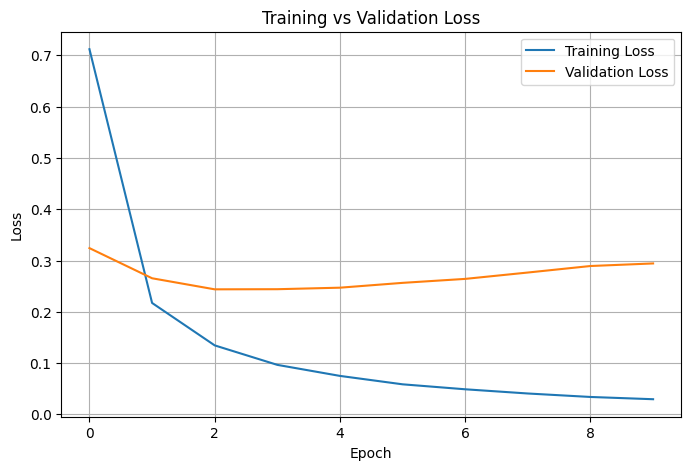

In [227]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [228]:
acc, report, true_tags, pred_tags = evaluate_lstm_model(modellstm, test_loader, idx2tag, device)

print(f"Accuracy: {100*acc:.2f}%")
print(f"Training time: {total_time:.4f}")
print(f"Report: {report}")

Accuracy: 92.94%
Training time: 26.3015
Report:               precision    recall  f1-score   support

         ADJ       0.91      0.87      0.89      1788
         ADP       0.95      0.97      0.96      2025
         ADV       0.93      0.90      0.92      1191
         AUX       0.98      0.98      0.98      1543
       CCONJ       1.00      0.99      1.00       736
         DET       0.99      0.99      0.99      1897
        INTJ       0.98      0.78      0.87       121
        NOUN       0.85      0.91      0.88      4123
         NUM       0.97      0.72      0.83       542
        PART       0.98      0.98      0.98       649
        PRON       0.99      0.99      0.99      2165
       PROPN       0.78      0.78      0.78      2075
       PUNCT       1.00      0.99      0.99      3096
       SCONJ       0.97      0.82      0.89       384
         SYM       0.82      0.88      0.85       113
        VERB       0.93      0.94      0.94      2606
           X       0.09      0.02

Teste para 100 DIM Embbedings

In [230]:
EMBEDDING_DIM = 100
GLOVE100 = "../Part1/data/wiki_giga_2024_100_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05.050_combined.txt"

glove_embeddings_matrix = load_glove_embeddings(GLOVE100, word2idx, EMBEDDING_DIM, unk_token=UNK_TOKEN, lower=True)

model100 = LSTMTagger(
    vocab_size=len(word2idx),
    tagset_size=len(tag2idx_lstm),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    pretrained_embeddings = glove_embeddings_matrix
).to(device)

print(f"LSTM Model parameters: {sum(p.numel() for p in model100.parameters())}")

Loaded GloVe: found 12299/20203 words from the provided vocabulary.
Loading pretrained embeddings...
LSTM Model parameters: 2260703


In [231]:
LEARNING_RATE = 0.001
EPOCHS = 10

# Training Loop
start_time = time.time()
print("\nStarting Training...")

train_losses, val_losses = train_model(model100, train_loader, val_loader, NUM_EPOCHS=10, learning_rate=0.001)


total_time = time.time() - start_time


Starting Training...
Epoch [1/10], Train Loss: 0.9092, Val Loss: 0.4202
Epoch [2/10], Train Loss: 0.3274, Val Loss: 0.3086
Epoch [3/10], Train Loss: 0.2218, Val Loss: 0.2701
Epoch [4/10], Train Loss: 0.1700, Val Loss: 0.2579
Epoch [5/10], Train Loss: 0.1353, Val Loss: 0.2548
Epoch [6/10], Train Loss: 0.1147, Val Loss: 0.2524
Epoch [7/10], Train Loss: 0.0987, Val Loss: 0.2493
Epoch [8/10], Train Loss: 0.0866, Val Loss: 0.2500
Epoch [9/10], Train Loss: 0.0763, Val Loss: 0.2528
Epoch [10/10], Train Loss: 0.0689, Val Loss: 0.2557


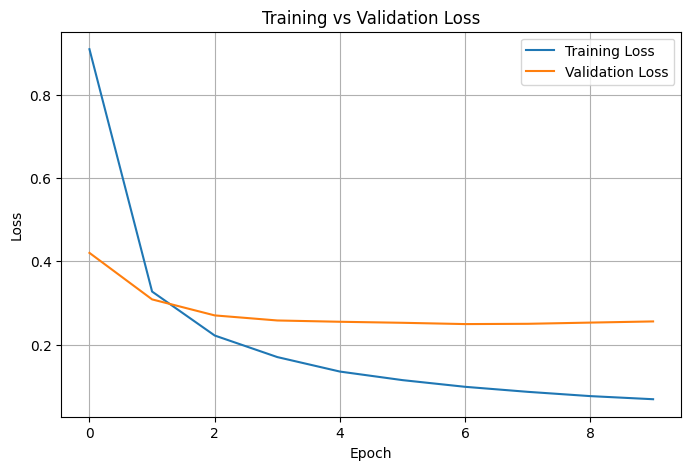

In [232]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [234]:
acc, report, true_tags, pred_tags = evaluate_lstm_model(model100, test_loader, idx2tag, device)

print(f"Accuracy: {100*acc:.2f}%")
print(f"Training time: {total_time:.4f}")
print(f"Report: {report}")

Accuracy: 92.99%
Training time: 16.3357
Report:               precision    recall  f1-score   support

         ADJ       0.92      0.86      0.89      1788
         ADP       0.95      0.96      0.96      2025
         ADV       0.93      0.91      0.92      1191
         AUX       0.98      0.99      0.99      1543
       CCONJ       1.00      0.99      0.99       736
         DET       0.99      0.99      0.99      1897
        INTJ       0.92      0.77      0.84       121
        NOUN       0.87      0.91      0.89      4123
         NUM       0.95      0.75      0.84       542
        PART       0.96      0.98      0.97       649
        PRON       0.99      0.99      0.99      2165
       PROPN       0.76      0.81      0.78      2075
       PUNCT       1.00      0.99      0.99      3096
       SCONJ       0.91      0.86      0.89       384
         SYM       0.84      0.86      0.85       113
        VERB       0.94      0.94      0.94      2606
           X       0.30      0.24

Teste para 200 DIM Embbedings

In [235]:
EMBEDDING_DIM = 200
GLOVE200 = "../Part1/data/wiki_giga_2024_200_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05_combined.txt"

glove_embeddings_matrix = load_glove_embeddings(GLOVE200, word2idx, EMBEDDING_DIM, unk_token=UNK_TOKEN, lower=True)

model200 = LSTMTagger(
    vocab_size=len(word2idx),
    tagset_size=len(tag2idx_lstm),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    pretrained_embeddings = glove_embeddings_matrix
).to(device)

print(f"LSTM Model parameters: {sum(p.numel() for p in model200.parameters())}")

Loaded GloVe: found 12299/20203 words from the provided vocabulary.
Loading pretrained embeddings...
LSTM Model parameters: 4383403


In [236]:
LEARNING_RATE = 0.001
EPOCHS = 10

# Training Loop
start_time = time.time()
print("\nStarting Training...")

train_losses, val_losses = train_model(model200, train_loader, val_loader, NUM_EPOCHS=10, learning_rate=0.001)


total_time = time.time() - start_time


Starting Training...
Epoch [1/10], Train Loss: 0.7735, Val Loss: 0.3580
Epoch [2/10], Train Loss: 0.2496, Val Loss: 0.2761
Epoch [3/10], Train Loss: 0.1606, Val Loss: 0.2543
Epoch [4/10], Train Loss: 0.1178, Val Loss: 0.2462
Epoch [5/10], Train Loss: 0.0921, Val Loss: 0.2459
Epoch [6/10], Train Loss: 0.0753, Val Loss: 0.2577
Epoch [7/10], Train Loss: 0.0622, Val Loss: 0.2658
Epoch [8/10], Train Loss: 0.0533, Val Loss: 0.2712
Epoch [9/10], Train Loss: 0.0463, Val Loss: 0.2719
Epoch [10/10], Train Loss: 0.0392, Val Loss: 0.2839


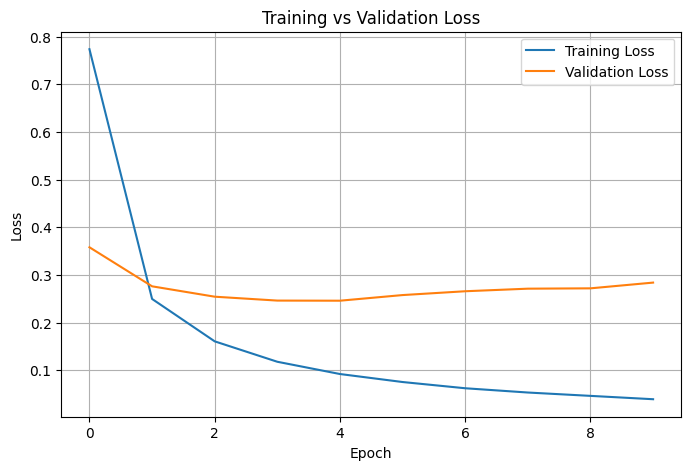

In [237]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [238]:
acc, report, true_tags, pred_tags = evaluate_lstm_model(model200, test_loader, idx2tag, device)

print(f"Accuracy: {100*acc:.2f}%")
print(f"Training time: {total_time:.4f}")
print(f"Report: {report}")

Accuracy: 92.92%
Training time: 21.5391
Report:               precision    recall  f1-score   support

         ADJ       0.88      0.89      0.88      1788
         ADP       0.95      0.97      0.96      2025
         ADV       0.93      0.91      0.92      1191
         AUX       0.99      0.99      0.99      1543
       CCONJ       0.99      0.99      0.99       736
         DET       0.99      0.99      0.99      1897
        INTJ       0.96      0.79      0.87       121
        NOUN       0.84      0.92      0.88      4123
         NUM       0.97      0.71      0.82       542
        PART       0.98      0.98      0.98       649
        PRON       0.98      0.99      0.99      2165
       PROPN       0.83      0.73      0.78      2075
       PUNCT       0.99      0.99      0.99      3096
       SCONJ       0.91      0.85      0.88       384
         SYM       0.88      0.81      0.85       113
        VERB       0.92      0.95      0.94      2606
           X       0.08      0.02

**Task 1.2 - Transformer-Based Encoder Model**

    Choose an encoder-based model (e.g., DistilBERT, BERT, RoBERTa, NeoBERT, EuroBERT)
    Ensure proper handling of subword tokenization (alignment between tokens and tags).
    Fine-tune the model for token-level classification (POS tagging).

Evaluate your model on the test set. Please take into account that the tokens being used by the model may not entirely correspond to existing the tokens

    Report the global performance using Accuracy
    Report the performance per-class using Precision, Recall, F1-score

Report training time, model size, and any hardware constraints.

In [239]:
import torch
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForTokenClassification
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import time

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Training on: {device}")

Training on: cuda


In [240]:
# --- Funções de Leitura de Dados ---

def read_conllu_file(filepath):
    """
    Read a CoNLL-U format file and extract words and POS tags sentence by sentence.
    
    Args:
        filepath: Path to the CoNLL-U file
        
    Returns:
        A list of dictionaries, each containing 'words' and 'pos_tags' lists for a sentence
    """
    sentences = []
    current_sentence = {'words': [], 'pos_tags': []}
    
    with open(filepath, "r", encoding="utf-8") as data_file:
        for line in data_file:
            if line.startswith("#"):
                # Skip comment lines
                pass
            elif line.strip() == "":
                # Empty line marks end of sentence
                if current_sentence['words']:  # Only add non-empty sentences
                    sentences.append(current_sentence)
                    current_sentence = {'words': [], 'pos_tags': []}
            else:
                # Parse the token line
                fields = line.split("\t")
                word, pos = fields[1], fields[3]
                current_sentence['words'].append(word)
                current_sentence['pos_tags'].append(pos)
    
    return sentences

#load data
TRAIN = "./data/en_ewt-ud-train.conllu"
DEV = "./data/en_ewt-ud-dev.conllu"
TEST = "./data/en_ewt-ud-test.conllu"

# --- 1) Carregar Dados ---
try:
    train_sents = read_conllu_file(TRAIN)
    val_sents = read_conllu_file(DEV)
    test_sents = read_conllu_file(TEST)
    print("Loaded sentences:", len(train_sents), len(val_sents), len(test_sents))
except FileNotFoundError as e:
    print(f"Erro: Ficheiro de dados não encontrado: {e.filename}. Certifique-se de que os ficheiros CoNLL-U estão em './data/'")
    exit()

# Display preview
print(f"Total sentences: {len(val_sents)}")
print(f"First 3 sentences:")
for i, sent in enumerate(val_sents[:3]):
    print(f"Sentence {i+1}:")
    print(f"  Words: {sent['words']}")
    print(f"  POS tags: {sent['pos_tags']}")

Loaded sentences: 12544 2001 2077
Total sentences: 2001
First 3 sentences:
Sentence 1:
  Words: ['From', 'the', 'AP', 'comes', 'this', 'story', ':']
  POS tags: ['ADP', 'DET', 'PROPN', 'VERB', 'DET', 'NOUN', 'PUNCT']
Sentence 2:
  Words: ['President', 'Bush', 'on', 'Tuesday', 'nominated', 'two', 'individuals', 'to', 'replace', 'retiring', 'jurists', 'on', 'federal', 'courts', 'in', 'the', 'Washington', 'area', '.']
  POS tags: ['PROPN', 'PROPN', 'ADP', 'PROPN', 'VERB', 'NUM', 'NOUN', 'PART', 'VERB', 'VERB', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'ADP', 'DET', 'PROPN', 'NOUN', 'PUNCT']
Sentence 3:
  Words: ['Bush', 'nominated', 'Jennifer', 'M.', 'Anderson', 'for', 'a', '15', '-', 'year', 'term', 'as', 'associate', 'judge', 'of', 'the', 'Superior', 'Court', 'of', 'the', 'District', 'of', 'Columbia', ',', 'replacing', 'Steffen', 'W.', 'Graae', '.']
  POS tags: ['PROPN', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'ADP', 'DET', 'NUM', 'PUNCT', 'NOUN', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'ADP', 'DET', 'ADJ', 'PROP

In [246]:
# --- Configuration ---
MAX_LEN = 128
BATCH_SIZE = 16
MODEL_NAME = 'distilbert-base-cased' # Case sensitive is usually better for POS

# --- 1. Label Mapping (Reusing from Task 1.1) ---
# We need to ensure we have the same tag map. 
# Re-running build_vocab just to be safe and self-contained
def get_tag_map(sentences):
    tags = set()
    for sent in sentences:
        for tag in sent['pos_tags']:
            tags.add(tag)
    tag2id = {tag: i for i, tag in enumerate(sorted(list(tags)))}
    id2tag_bert = {i: tag for tag, i in tag2id.items()}
    return tag2id, id2tag_bert

# Load data (assuming sentences are already loaded from previous task)
# train_sentences, dev_sentences, test_sentences are available
tag2id, id2tag_bert = get_tag_map(train_sents)
num_labels = len(tag2id)

print(f" distinctive tags: {num_labels}")

# --- 2. Tokenization & Alignment Function ---
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

class TransformerPOSDataset(torch.utils.data.Dataset):
    def __init__(self, sentences, tag2id, tokenizer, max_len):
        self.sentences = sentences
        self.tag2id = tag2id
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        item = self.sentences[idx]
        word_list = item['words']
        label_list = item['pos_tags']
        
        # Tokenize the sentence
        # is_split_into_words=True tells the tokenizer we are providing a list of words
        encoding = self.tokenizer(
            word_list,
            is_split_into_words=True,
            return_offsets_mapping=True, 
            padding='max_length', 
            truncation=True, 
            max_length=self.max_len,
            return_tensors='pt'
        )
        
        # Create labels aligned with tokens
        labels = []
        encoded_labels = []
        
        # The offset mapping helps us determine which original word a token belongs to
        # It returns tuples (start, end) char indices. (0,0) usually means special token.
        doc_encodings = encoding.encodings[0]
        
        # word_ids returns a list where each element indicates the index of the word 
        # in the original sentence that the token corresponds to. 
        # None indicates special tokens like [CLS] or [SEP].
        word_ids = encoding.word_ids()
        
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                # Special token ([CLS], [SEP], [PAD]) -> Ignore (-100)
                encoded_labels.append(-100)
            elif word_idx != previous_word_idx:
                # First subword of a new word -> Use the real label
                tag = label_list[word_idx]
                encoded_labels.append(self.tag2id[tag])
            else:
                # Subsequent subword of the same word -> Ignore (-100)
                # Alternatively, you could propagate the label, but -100 is standard
                encoded_labels.append(-100)
            previous_word_idx = word_idx
            
        # Squeeze to remove batch dimension added by tokenizer
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(encoded_labels)
        
        # Remove offset_mapping as it's not needed for the model
        if 'offset_mapping' in item:
             del item['offset_mapping']
             
        return item

# Create Datasets
train_dataset = TransformerPOSDataset(train_sents, tag2id, tokenizer, MAX_LEN)
test_dataset = TransformerPOSDataset(test_sents, tag2id, tokenizer, MAX_LEN)
val_dataset = TransformerPOSDataset(val_sents, tag2id, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

 distinctive tags: 18


In [247]:
def train_model_early_stopping(model, train_loader, val_loader,
                               NUM_EPOCHS=10, learning_rate=1e-4, device='cuda',
                               patience=2, verbose=True):
    """
    The model is trained using early stopping based on validation loss.
    patience: number of consecutive epochs with no improvement before stopping.
    If the validation loss improves, the best model weights are saved. 
    The best model weights are restored before returning.
    """
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_state = None

    model.to(device)

    for epoch in range(NUM_EPOCHS):
        model.train()
        running_train_loss = 0.0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                running_val_loss += loss.item()

        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)

        if verbose:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]  Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}")

        # Check improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            # save best model weights (in memory)
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            if verbose:
                print(f"  --> Improvement. Best val loss: {best_val_loss:.4f}")
        else:
            epochs_no_improve += 1
            if verbose:
                print(f"  --> No improvement for {epochs_no_improve}/{patience} epochs.")
            if epochs_no_improve >= patience:
                if verbose:
                    print(f"Early stopping triggered after epoch {epoch+1}.")
                stopped_epoch = epoch + 1
                # restore best weights before returning
                if best_state is not None:
                    model.load_state_dict({k: v.to(model.device) for k, v in best_state.items()})
                return train_losses, val_losses, stopped_epoch, model

    # training finished normally
    if best_state is not None:
        model.load_state_dict({k: v.to(model.device) for k, v in best_state.items()})
    return train_losses, val_losses, NUM_EPOCHS, model


In [248]:
model_bert = DistilBertForTokenClassification.from_pretrained(
    MODEL_NAME, 
    num_labels=num_labels
).to(device)

print(f"Bert Model parameters: {sum(p.numel() for p in model_bert.parameters())}")

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Bert Model parameters: 65204754


In [249]:
EPOCHS = 10
LEARNING_RATE = 5e-5
PATIENCE = 1   # change to 0 to stop on first increase, or >0 to allow that many non-improving epochs

start_time = time.time()
print("Starting Fine-tuning...")

# Option A: strict immediate stop on first increase
# train_losses, val_losses, stopped_epoch, trained_model = train_model_stop_on_increase(
#     model_bert, train_loader, val_loader, EPOCHS, LEARNING_RATE, device=device)

# Option B: recommended patience-based early stopping
train_losses, val_losses, stopped_epoch, trained_model = train_model_early_stopping(
    model_bert, train_loader, val_loader,
    NUM_EPOCHS=EPOCHS, learning_rate=LEARNING_RATE,
    device=device, patience=PATIENCE, verbose=True)

training_time = time.time() - start_time
print(f"Training stopped at epoch {stopped_epoch}. Total training time: {training_time:.1f} seconds.")


Starting Fine-tuning...
Epoch [1/10]  Train Loss: 0.1983  Val Loss: 0.1204
  --> Improvement. Best val loss: 0.1204
Epoch [2/10]  Train Loss: 0.0525  Val Loss: 0.1188
  --> Improvement. Best val loss: 0.1188
Epoch [3/10]  Train Loss: 0.0268  Val Loss: 0.1280
  --> No improvement for 1/1 epochs.
Early stopping triggered after epoch 3.
Training stopped at epoch 3. Total training time: 529.9 seconds.


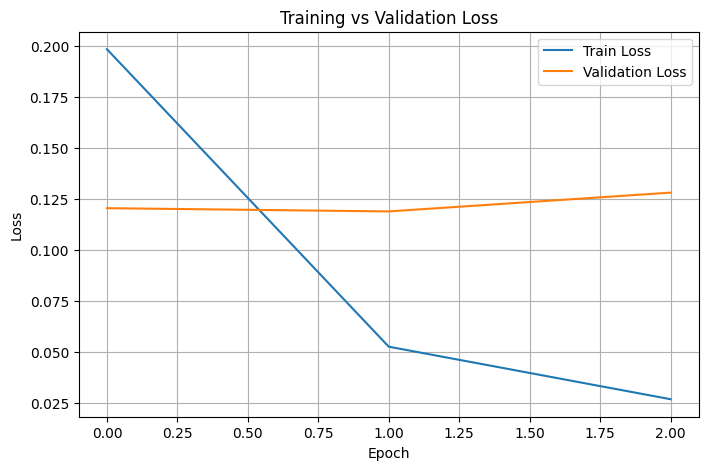

In [250]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [251]:
def evaluate_bert_model(model, loader, id2tag):
    model.eval()
    
    all_labels = []
    all_pred = []
    
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits # Shape: (batch, seq_len, num_labels)
            predictions = torch.argmax(logits, dim=2)
            
            # Flatten to align
            predictions = predictions.view(-1).cpu().numpy()
            labels = labels.view(-1).cpu().numpy()
            
            # Filter out ignored indices (-100)
            # This ensures we only evaluate on the first subword of real words
            valid_indices = labels != -100
            
            valid_preds = predictions[valid_indices]
            valid_targets = labels[valid_indices]
            
            all_labels.extend(valid_targets)
            all_pred.extend(valid_preds)

    # Convert ids back to tags
    true_tags = [id2tag[i] for i in all_labels]
    pred_tags = [id2tag[i] for i in all_pred]
    
    acc = accuracy_score(true_tags, pred_tags)
    report = classification_report(true_tags, pred_tags, zero_division=0)
    
    return acc, report, true_tags, pred_tags

In [253]:
acc, report, true_tags, pred_tags = evaluate_bert_model(model_bert, test_loader, id2tag_bert)

print(f"Accuracy: {100*acc:.4f}%")
print(f"Training time: {training_time:.2f} seconds")
print(f"Report: \n{report}")

Accuracy: 96.6719%
Training time: 529.89 seconds
Report: 
              precision    recall  f1-score   support

         ADJ       0.92      0.96      0.94      1788
         ADP       0.98      0.97      0.98      2025
         ADV       0.96      0.94      0.95      1191
         AUX       1.00      0.99      1.00      1543
       CCONJ       1.00      1.00      1.00       736
         DET       0.99      0.99      0.99      1897
        INTJ       0.89      0.89      0.89       121
        NOUN       0.96      0.93      0.94      4123
         NUM       0.96      0.98      0.97       542
        PART       1.00      0.99      0.99       649
        PRON       0.99      0.99      0.99      2165
       PROPN       0.89      0.92      0.91      2075
       PUNCT       0.99      1.00      0.99      3096
       SCONJ       0.94      0.96      0.95       384
         SYM       0.85      0.83      0.84       113
        VERB       0.98      0.98      0.98      2606
           X       0.46

**Task 1.3 - Use LLMs to perform the task in the test set (optional, only if you have time)**

    Choose an existing LLM of your choice (e.g., ChatGPT)
    Define a prompt and perform the classification.
    Report the performance of the model, and compare it with your previous models.
    
**Comparison and Analysis**

    Compare the performance of the previous models, in terms of:
        Quantitative performance (metrics)
        Qualitative behavior (e.g., errors, generalization)
        Computational efficiency and training stability

    Discuss potential reasons for performance differences.
    Optionally visualize:
        Confusion matrices
        Learning curves

I asked the LLM for a good prompt for the pourpose. We got:
----------
TASK: Define a Prompt

An efficient prompt should:

Explain the task

Garantir que o output está alinhado com as classes de POS do dataset Make sure the output is aligned witg the POS calsses from the dataset

Return only tags withuot noise


Prompt Recomendado:
--------------------


You are a POS-tagging model. Your task is to assign exactly one POS tag to each token.
Use only the following tagset: [LISTA_DE_TAGS_AQUI].

Return the result strictly as a list of tags, one per word.

Sentence:
{sentence}

Word list:
{token_list}

Respond only with the POS tags in order, separated by spaces.

In [254]:
# Example sentences (tokens + gold tags) — ready for evaluation
example_sents = [
    # 1
    {
        "words": ["From", "the", "AP", "comes", "this", "story", ":"],
        "pos_tags": ["ADP", "DET", "PROPN", "VERB", "DET", "NOUN", "PUNCT"]
    },
    # 2
    {
        "words": ["President", "Bush", "on", "Tuesday", "nominated", "two", "individuals", "to", "replace", "retiring", "jurists", "."],
        "pos_tags": ["PROPN","PROPN","ADP","PROPN","VERB","NUM","NOUN","PART","VERB","VERB","NOUN","PUNCT"]
    },
    # 3
    {
        "words": ["The", "new", "policy", "introduced", "last", "week", "has", "already", "caused", "several", "unexpected", "issues", "," , "according", "to", "experts", "."],
        "pos_tags": ["DET","ADJ","NOUN","VERB","ADJ","NOUN","AUX","ADV","VERB","DET","ADJ","NOUN","PUNCT","VERB","ADP","NOUN","PUNCT"]
    },
    # 4
    {
        "words": ["She", "is", "the", "first", "to", "announce", "her", "resignation", "today", "."],
        "pos_tags": ["PRON","AUX","DET","ADJ","PART","VERB","PRON","NOUN","PROPN","PUNCT"]
    },
    # 5
    {
        "words": ["If", "the", "court", "rules", "against", "the", "company", ",", "it", "may", "face", "heavy", "fines", "."],
        "pos_tags": ["SCONJ","DET","NOUN","VERB","ADP","DET","NOUN","PUNCT","PRON","AUX","VERB","ADJ","NOUN","PUNCT"]
    },
    # 6
    {
        "words": ["Wow", "!", "That", "decision", "really", "surprised", "the", "entire", "board", "."],
        "pos_tags": ["INTJ","PUNCT","DET","NOUN","ADV","VERB","DET","ADJ","NOUN","PUNCT"]
    },
    # 7
    {
        "words": ["Only", "3", "of", "the", "candidates", "attended", "the", "meeting", "."],
        "pos_tags": ["ADV","NUM","ADP","DET","NOUN","VERB","DET","NOUN","PUNCT"]
    },
    # 8
    {
        "words": ["He", "said", "that", "the", "economy", "was", "improving", "but", "employment", "lags", "."],
        "pos_tags": ["PRON","VERB","SCONJ","DET","NOUN","AUX","VERB","CCONJ","NOUN","VERB","PUNCT"]
    },
    # 9
    {
        "words": ["Microsoft", "and", "Apple", "announced", "a", "partnership", "on", "Monday", "."],
        "pos_tags": ["PROPN","CCONJ","PROPN","VERB","DET","NOUN","ADP","PROPN","PUNCT"]
    },
    # 10 (contains a token with uncertain tag -> X)
    {
        "words": ["The", "symbol", "§", "appeared", "in", "the", "document", "."],
        "pos_tags": ["DET","NOUN","SYM","VERB","ADP","DET","NOUN","PUNCT"]
    }
]

example_dataset_bert = TransformerPOSDataset(example_sents, tag2id, tokenizer, MAX_LEN)
example_loader_bert = DataLoader(example_dataset_bert, batch_size=1, shuffle=False)

example_dataset_lstm = POSDataset(example_sents, word2idx, tag2idx_lstm)
example_loader_lstm = DataLoader(example_dataset_lstm, batch_size=1, shuffle=False)

In [255]:
# --- CALL the LLM per sentence (recommended) ---

acc_lstm, report_lstm, true_tags_lstm, pred_tags_lstm = evaluate_lstm_model(modellstm, example_loader_lstm, idx2tag, device)

print(f"Accuracy: {100*acc_lstm:.4f}%")
print(f"Report: \n{report_lstm}")   

acc_bert, report_bert, true_tags_bert, pred_tags_bert = evaluate_bert_model(model_bert, example_loader_bert, id2tag_bert) 

print(f"Accuracy: {100*acc_bert:.4f}%")
print(f"Report: \n{report_bert}")

Accuracy: 92.5234%
Report: 
              precision    recall  f1-score   support

         ADJ       0.86      1.00      0.92         6
         ADP       0.88      1.00      0.93         7
         ADV       1.00      1.00      1.00         3
         AUX       1.00      1.00      1.00         4
       CCONJ       1.00      0.50      0.67         2
         DET       1.00      0.93      0.97        15
        INTJ       1.00      1.00      1.00         1
        NOUN       0.79      0.95      0.86        20
         NUM       1.00      1.00      1.00         2
        PART       1.00      1.00      1.00         2
        PRON       1.00      1.00      1.00         4
       PROPN       0.86      0.75      0.80         8
       PUNCT       1.00      1.00      1.00        13
       SCONJ       1.00      1.00      1.00         2
         SYM       0.00      0.00      0.00         1
        VERB       1.00      0.88      0.94        17

    accuracy                           0.93       10

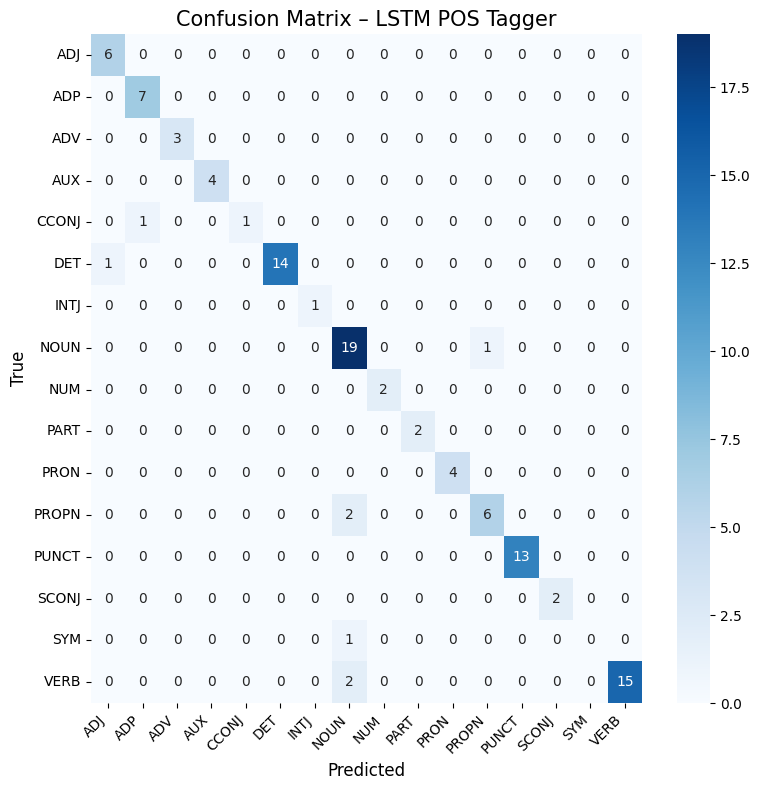

In [269]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Opcional: excluir tags que não te interessam na visualização
tags_to_include = sorted(
    set(true_tags_lstm + pred_tags_lstm) - {"<PAD>", "X", "_"}
)

cm_lstm = confusion_matrix(true_tags_lstm, pred_tags_lstm, labels=tags_to_include)

plt.figure(figsize=(8, 8))
sns.heatmap(
    cm_lstm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=tags_to_include,
    yticklabels=tags_to_include
)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.title("Confusion Matrix – LSTM POS Tagger", fontsize=15)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


The LSTM model present confusion for the NOUN class.

Other missclassifications:

DET for ADJ

NOUN or AUX

DET for PRON 

NOUN for PROPN

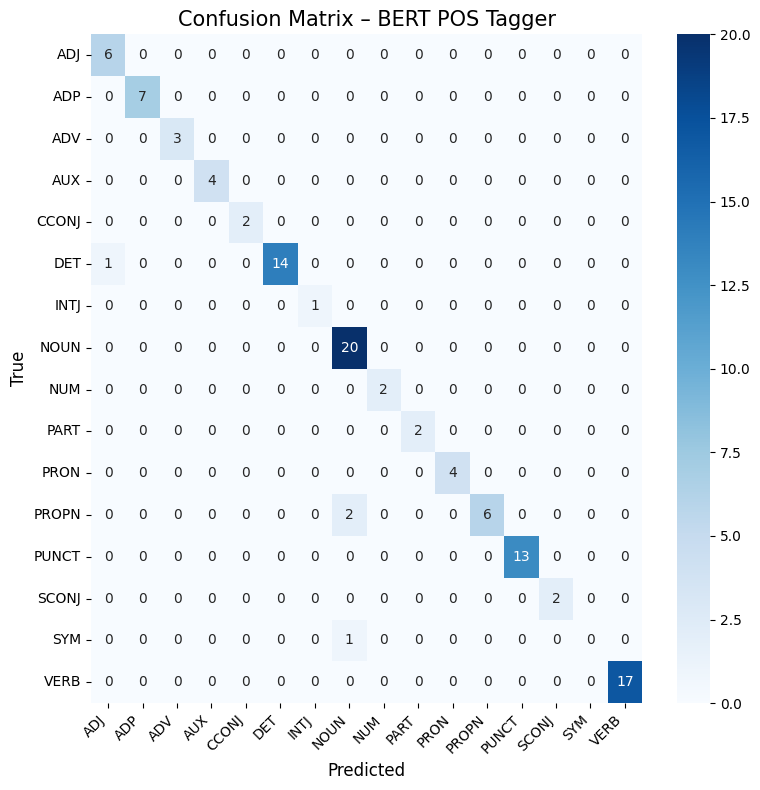

In [267]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Remover classes "X" e "_" se não te interessarem
tags_to_include = [t for t in sorted(set(true_tags_bert + pred_tags_bert)) if t not in {"_", "X"}]

cm = confusion_matrix(true_tags_bert, pred_tags_bert, labels=tags_to_include)

plt.figure(figsize=(8, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=tags_to_include,
    yticklabels=tags_to_include
)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.title("Confusion Matrix – BERT POS Tagger", fontsize=15)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


It is more precise than the LSTM model WITH ~5.5% ACC increase.

It also confuses PROPN with NOUN'S

Other missclassifications:

DET ADJ

A BIGGER SET WOULD PROBABLY SHOW A FUZZIER RESULT FOR THE CLASS CLASSIFICATIONS